# Prediction of energy for single electron event
This notebook aims to build a model able to predict the energy of the electrons in a double-electron event.

## TODO / Status

In [1]:
"""
Here are the data files.  For all data files each image and label is on one row.  
The first 256 values in each row correspond to the 16x16 detector image and 
the last 6 values correspond to Energy1, Xpos1, Ypos1, Energy2, Xpos2, Ypos2.  
If there is no second particle then Energy2 = 0 and Xpos2 and Ypos2 are both -100.  
(When I run my model, I have to reset the -100 to 0).
 
CeBr10kSingle are 10,000 rows of data and labels for single interactions in the detector
CeBr10k_1.txt is 10,000 rows of data and labels with a mix of single interactions and double interactions
CeBr10.txt is a small file I use which contains 10 single interactions.
"""

import numpy as np
import matplotlib.pyplot as plt
from data_functions import separate_simulated_data

# File import
PATH = "../data/small_sample/"
filenames = ["CeBr10kSingle_1.txt", "CeBr10kSingle_2.txt", "CeBr10k_1.txt", "CeBr10.txt"]

## single, mix, small define which dataset to load.
file_to_load = "mix"

if file_to_load == "single_1":
    infile = PATH+filenames[0]
if file_to_load == "single_2":
    infile = PATH+filenames[1]
if file_to_load == "mix":
    infile = PATH+filenames[2]
if file_to_load == "small":
    infile = PATH+filenames[3]
if file_to_load == "combined_single":
    infile = PATH+filenames[0]
    infile2 = PATH+filenames[1]

data = np.loadtxt(infile)

if file_to_load == "combined_single":
    data2 = np.loadtxt(infile2)
    data = np.concatenate((data, data2))

# Extract the data containing double events. 
# data[:, -3] is Energy2, which is 0 if the data is a single event
double_events = data[np.where(data[:,-3] != 0)]
images, energies, positions = separate_simulated_data(double_events)




print("Image data shape: {}".format(images.shape))
print("Energies shape: {}".format(energies.shape))
print("Positions shape: {}".format(positions.shape))
      

Image data shape: (4998, 16, 16, 1)
Energies shape: (4998, 2)
Positions shape: (4998, 4)



## Set up training and test data

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, energies, test_size = 0.1)
print("Training and test data shapes:")
print("x_train: {}".format(x_train.shape))
print("x_test: {}".format(x_test.shape))
print("y_train: {}".format(y_train.shape))
print("y_test: {}".format(y_test.shape))




Training and test data shapes:
x_train: (4498, 16, 16, 1)
x_test: (500, 16, 16, 1)
y_train: (4498, 2)
y_test: (500, 2)


## Build and compile model
Using Keras as our framework with Tensorflow backend

In [3]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras import backend
import warnings

# Set up sequetial model like Keras CIFAR-10 example
model = Sequential()

# Add layers
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=x_train.shape[1:]))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

#model.add(Conv2D(64, (3, 3), padding='same'))
#model.add(Activation('relu'))
#model.add(Conv2D(64, (3, 3)))
#model.add(Activation('relu'))
#model.add(MaxPooling2D(pool_size=(2, 2)))
#model.add(Dropout(0.25))

model.add(Flatten())
#model.add(Dense(128))
#model.add(Activation('relu'))
#model.add(Dropout(0.5))
model.add(Dense(2))
model.add(Activation('linear'))



# Custom definition of R2 score for metrics
def r2_keras(y_true, y_pred):
    SS_res =  backend.sum(backend.square(y_true - y_pred)) 
    SS_tot = backend.sum(backend.square(y_true - backend.mean(y_true))) 
    return ( 1 - SS_res/(SS_tot + backend.epsilon()) )

# Compile model
model.compile(loss='mse',
              optimizer='adam',
              metrics=[r2_keras])

# Output summary of model
print(model.summary())



Using TensorFlow backend.
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ulvik/.local/lib/python3.7/site-packages/tensorflow/python/fra

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 16, 16, 32)        320       
_________________________________________________________________
activation_1 (Activation)    (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 32)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6272)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 12546     
_________________________________________________________________
activation_3 (Activation)    (None, 2)                 0         
Total para

## Train the model
We also output the mean squared error and R2-score as evaluation metrics

In [4]:
# Parameters for the model
batch_size = 32
epochs = 25

history = model.fit(x_train, y_train, 
                    batch_size=batch_size, 
                    epochs=epochs, 
                    validation_data=(x_test, y_test), 
                    shuffle=True)

W0803 14:28:46.498846 140437615535744 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0803 14:28:46.625821 140437615535744 deprecation_wrapper.py:119] From /home/ulvik/.local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 4498 samples, validate on 500 samples
Epoch 1/25
4498/4498 [==============================] - 2s 537us/step - loss: 119.1041 - r2_keras: -1420.2328 - val_loss: 1.1107 - val_r2_keras: -13.4540
Epoch 2/25
4498/4498 [==============================] - 2s 472us/step - loss: 0.5213 - r2_keras: -5.4539 - val_loss: 0.6366 - val_r2_keras: -7.4491
Epoch 3/25
4498/4498 [==============================] - 2s 476us/step - loss: 0.3437 - r2_keras: -3.2865 - val_loss: 0.5551 - val_r2_keras: -6.4197
Epoch 4/25
4498/4498 [==============================] - 2s 502us/step - loss: 0.2930 - r2_keras: -2.6391 - val_loss: 0.5147 - val_r2_keras: -5.9154
Epoch 5/25
4498/4498 [==============================] - 2s 493us/step - loss: 0.2581 - r2_keras: -2.2218 - val_loss: 0.4869 - val_r2_keras: -5.5798
Epoch 6/25
4498/4498 [==============================] - 2s 494us/step - loss: 0.2288 - r2_keras: -1.8402 - val_loss: 0.4625 - val_r2_keras: -5.2784
Epoch 7/25
4498/4498 [==============================] - 2s 

## Plot history of metrics on training and test set

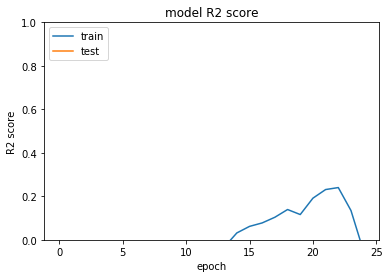

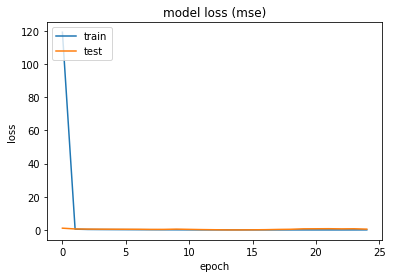

In [5]:
%matplotlib inline

plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model R2 score')
plt.ylabel('R2 score')
plt.xlabel('epoch')
plt.axis(ymin=0, ymax=1) # limit to view the interesting part of R2
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss (mse)')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()